In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import torch
import torch.nn.functional as F

# Adam, additivity

torch.set_default_dtype(torch.float64)


def f_(X):
    return torch.sin(np.pi*X)
    #return X**2

def f(X,Y):
    return f_(X)*f_(Y)


n_grids = [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150]
#n_grids = [10,20]
#n_grids = [5]

errors = []
errors_test = []

ii = 0

for n_grid in n_grids:
    print("n_grid={}".format(n_grid))
    #n_grid = 400


    x = torch.linspace(-1,1,steps=n_grid)
    y = torch.linspace(-1,1,steps=n_grid)
    x_test = torch.linspace(-1,1,steps=2*n_grid-1)[1:-1:2]
    y_test = torch.linspace(-1,1,steps=2*n_grid-1)[1:-1:2]
    X, Y = torch.meshgrid(x, y)

    # full have shape (2, n_grid)
    def add(full):
        return full[0,:].unsqueeze(dim=0) * full[1,:].unsqueeze(dim=1)
        

    def add_loss(full, x, y):
        f_numerical = add(full)
        X, Y = torch.meshgrid(x[:],y[:])
        f_true = f(X,Y)
        return torch.mean((f_numerical-f_true)**2)

    # initalize z as random parameters, note sequential training
    #z = g(X,Y)
    #if ii == 0:
    if True:
        z = torch.stack([f_(x), f_(y)])
        #z = torch.normal(0,1,size=(2,n_grid))*0.001
        z = torch.nn.Parameter(z, requires_grad=True)
    else:
        z = F.interpolate(z.unsqueeze(dim=0).unsqueeze(dim=0), size=(2,n_grid), mode='bilinear', align_corners=True)[0,0]
        z = torch.nn.Parameter(z, requires_grad=True)
        
    ii = ii + 1
    
    # initialize adam (learning rate scaling lr~h**4), z as parameters
    lr = 1e-2
    opt = torch.optim.Adam({z}, lr=lr, eps=1e-8)
    #opt = torch.optim.SGD({z}, lr=lr)
    
    # iterations here (learning rate decay)
    epochs = 1#50000
    switch_epoch = 5000
    log = 100
    best_loss = 1e20
    losses = []
    
    for i in range(epochs):
        if (i+1) % switch_epoch == 0:
            for opt_param in opt.param_groups:
                lr = lr * 0.5
                opt_param['lr'] = lr
        
        def loss_closure():
            opt.zero_grad()
            loss_train = add_loss(z, x, y)
            z_interp = F.interpolate(z.unsqueeze(dim=0).unsqueeze(dim=0), size=(2,2*n_grid-1), mode='bilinear', align_corners=True)[0,0]
            z_test = z_interp[:,1:-1:2]
            loss_test = add_loss(z_test, x_test, y_test)
            loss = (loss_test*(n_grid-1)**2 + loss_train*(n_grid)**2)/((n_grid-1)**2+(n_grid)**2)
            loss.backward()
            return loss
          # -------------------------------------------
        loss = loss_closure()
        opt.step(loss_closure)  # get loss, use to update wts
        if loss < best_loss:
            best_loss = loss
            best_epoch = i
            best_z = z.clone()
        if i % log == 0:
            print("Epoch: {}".format(i) + " | " + "Loss: {}".format(loss.detach().numpy()))
        losses.append(loss.detach().numpy())
    
    errors.append(best_loss.detach().numpy())
    
    torch.save(z, './mult_results_grid/z_n_{}'.format(n_grid))
    torch.save(best_loss, './mult_results_grid/loss_n_{}'.format(n_grid))


n_grid=10
Epoch: 0 | Loss: 0.0015309224482859933
n_grid=15
Epoch: 0 | Loss: 0.0002853628807018392
n_grid=20
Epoch: 0 | Loss: 8.704118250581474e-05
n_grid=25
Epoch: 0 | Loss: 3.480247735801745e-05
n_grid=30
Epoch: 0 | Loss: 1.650234302382433e-05
n_grid=35
Epoch: 0 | Loss: 8.797304875491942e-06
n_grid=40
Epoch: 0 | Loss: 5.107841162152308e-06
n_grid=45
Epoch: 0 | Loss: 3.1648494045368993e-06
n_grid=50
Epoch: 0 | Loss: 2.0638224230642125e-06
n_grid=55
Epoch: 0 | Loss: 1.4025306595232648e-06
n_grid=60
Epoch: 0 | Loss: 9.86097611762069e-07
n_grid=65
Epoch: 0 | Loss: 7.133560207537165e-07
n_grid=70
Epoch: 0 | Loss: 5.28711791496737e-07
n_grid=75
Epoch: 0 | Loss: 4.0012169103866637e-07
n_grid=80
Epoch: 0 | Loss: 3.083514501168364e-07
n_grid=85
Epoch: 0 | Loss: 2.4144449548024383e-07
n_grid=90
Epoch: 0 | Loss: 1.9173839841440505e-07
n_grid=95
Epoch: 0 | Loss: 1.541894331778641e-07
n_grid=100
Epoch: 0 | Loss: 1.2539794528842177e-07
n_grid=105
Epoch: 0 | Loss: 1.0302345208684536e-07
n_grid=110
E

/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1639180852547/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Text(0.5, 1.0, 'Grid: slope=4/d=3.995, d=1.001')

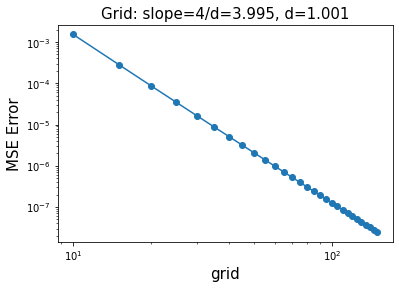

In [2]:
plt.plot(n_grids, errors, marker="o")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('grid',fontsize=15)
plt.ylabel('MSE Error',fontsize=15)
plt.title("Grid: slope=4/d=3.995, d=1.001",fontsize=15)

In [3]:
start_id = 10
end_id = -1
(np.log(errors[end_id])-np.log(errors[start_id]))/(np.log(n_grids[end_id]-1)-np.log(n_grids[start_id]-1))

-3.9872292016309125